<a href="https://colab.research.google.com/github/akimi-yano/FloodNet_Semantic_Segmentation/blob/main/FloodNet_Semantic_Segmentation_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
open_cv_tf_project_3_image_segmentation_round_3_path = kagglehub.competition_download('open-cv-tf-project-3-image-segmentation-round-3')

print('Data source import complete.')

100%|██████████| 438M/438M [00:04<00:00, 114MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c open-cv-tf-project-3-image-segmentation-round-3

 96% 422M/438M [00:02<00:00, 218MB/s]
100% 438M/438M [00:02<00:00, 211MB/s]


In [ ]:
!unzip open-cv-tf-project-3-image-segmentation-round-3.zip -d dataset/

Archive:  open-cv-tf-project-3-image-segmentation-round-3.zip
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10181.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10806.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10811.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10826.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10833.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10834.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10836.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/10841.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/6332.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/6334.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/6336.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/6337.jpg  
  inflating: dataset/Project_3_FloodNet_Dataset/test/images/6340.jpg  
  infla

In [ ]:
import os
data_root = './dataset'
os.path.exists(data_root)
for elem in os.walk(data_root):
  print(elem)

('./dataset', ['Project_3_FloodNet_Dataset'], ['sample_submission.csv', 'test.csv'])
('./dataset/Project_3_FloodNet_Dataset', ['train', 'test'], [])
('./dataset/Project_3_FloodNet_Dataset/train', ['images', 'masks'], [])
('./dataset/Project_3_FloodNet_Dataset/train/images', [], ['7988.jpg', '8260.jpg', '7431.jpg', '7051.jpg', '7144.jpg', '8011.jpg', '8939.jpg', '9888.jpg', '6801.jpg', '7119.jpg', '8991.jpg', '6782.jpg', '7885.jpg', '7781.jpg', '6911.jpg', '7655.jpg', '8301.jpg', '7843.jpg', '9051.jpg', '7206.jpg', '6919.jpg', '6346.jpg', '7971.jpg', '7703.jpg', '7984.jpg', '7126.jpg', '8297.jpg', '8502.jpg', '7598.jpg', '6687.jpg', '8257.jpg', '9231.jpg', '7815.jpg', '8233.jpg', '7748.jpg', '7127.jpg', '6903.jpg', '7455.jpg', '9033.jpg', '9367.jpg', '8419.jpg', '8513.jpg', '9055.jpg', '6544.jpg', '7837.jpg', '7420.jpg', '8129.jpg', '7787.jpg', '7711.jpg', '7334.jpg', '6754.jpg', '7719.jpg', '6773.jpg', '7486.jpg', '8290.jpg', '6927.jpg', '7992.jpg', '8785.jpg', '6642.jpg', '6713.jpg', 

# FloodNet - Semantic Segmentation

## 1. Custom Dataset Class

In [ ]:
import os
import cv2
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from dataclasses import dataclass

# Try to import tf.keras, otherwise fall back to standalone keras.
try:
    from tensorflow.keras.models import Model
    from tensorflow.keras.utils import to_categorical, Sequence
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
    from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
    from tensorflow.keras.applications import VGG16
except ModuleNotFoundError:
    import keras
    from keras.models import Model
    from keras.utils import to_categorical, Sequence
    from keras.optimizers import Adam
    from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
    from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
    from keras.applications import VGG16

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['image.cmap'] = 'gray'
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Test TensorFlow and Keras versions:
print("TensorFlow version:", tf.__version__)
try:
    print("tf.keras version:", keras.__version__)
except Exception as e:
    print("Error obtaining keras version:", e)


TensorFlow version: 2.18.0
Error obtaining keras version: name 'keras' is not defined


In [ ]:
def system_config(SEED_VALUE=42):
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    if gpu_devices:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

random_state = 30
system_config(random_state)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_WIDTH: int = 224
    IMG_HEIGHT: int = 224
    ROOT_DIR: str = './dataset'
    DATASET_DIR: str = os.path.join(ROOT_DIR, 'Project_3_FloodNet_Dataset')
    DATA_TRAIN_IMAGES: str = os.path.join(DATASET_DIR, 'train/images/*.jpg')
    DATA_TRAIN_LABELS: str = os.path.join(DATASET_DIR, 'train/masks/*.png')
    DATA_TEST_IMAGES: str = os.path.join(DATASET_DIR, 'test/images/*.jpg')
    DATA_TEST_LABELS: str = os.path.join(DATASET_DIR, 'test/masks/*.png')

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:         int = 8
    EPOCHS:             int = 35                # Feature extraction stage epochs
    EPOCHS_FT:          int = 10                 # Fine-tuning stage epochs
    LEARNING_RATE:      float = 1e-4
    LEARNING_RATE_FT:   float = 1e-6

# Define a color map (id2color) for the classes
id2color = {
    0: (0, 0, 0),         # Background
    1: (255, 0, 0),       # Building Flooded
    2: (200, 90, 90),     # Building Non-Flooded
    3: (128, 128, 0),     # Road Flooded
    4: (155, 155, 155),   # Road Non-Flooded
    5: (0, 255, 255),     # Water
    6: (55, 0, 255),      # Tree
    7: (255, 0, 255),     # Vehicle
    8: (245, 245, 0),     # Pool
    9: (0, 255, 0)        # Grass
}

In [ ]:
def rgb_to_class_id(mask, color_map):
    """Convert an RGB mask to a class ID mask."""
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for class_id, color in color_map.items():
        class_mask[np.all(mask == color, axis=-1)] = class_id
    return class_mask

class CustomSegmentationDataset(Sequence):
    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, apply_aug):
        self.batch_size = batch_size
        self.image_size = image_size  # (height, width)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes = num_classes
        self.apply_aug = apply_aug
        # Use minimal geometric and color augmentations
        self.transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.CLAHE(clip_limit=4.0, p=0.5),
            A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.3),
        ]) if apply_aug else None
        self.resize = A.Resize(height=image_size[0], width=image_size[1], interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images, batch_masks = [], []
        start = idx * self.batch_size
        batch_image_paths = self.image_paths[start: start + self.batch_size]
        batch_mask_paths = self.mask_paths[start: start + self.batch_size]
        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            try:
                img = cv2.imread(img_path)
                if img is None:
                    logging.warning(f"Could not read image: {img_path}. Skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

                mask = cv2.imread(mask_path)
                if mask is None:
                    logging.warning(f"Could not read mask: {mask_path}. Skipping.")
                    continue
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB).astype(np.uint8)
                mask = rgb_to_class_id(mask, id2color)

                resized = self.resize(image=img, mask=mask)
                img, mask = resized['image'], resized['mask']

                if self.transforms:
                    augmented = self.transforms(image=img, mask=mask)
                    img, mask = augmented['image'], augmented['mask']

                mask = to_categorical(mask, num_classes=self.num_classes)
                batch_images.append(img)
                batch_masks.append(mask)
            except Exception as e:
                logging.error(f"Error processing {img_path} or {mask_path}: {e}")
        return np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

## 2. Visualize Dataset

In [ ]:
def num_to_rgb(mask, color_map):
    """Convert a class ID mask to an RGB mask using the provided color map."""
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

def image_overlay(image, mask, alpha=0.5):
    """Overlay the mask on the image."""
    return cv2.addWeighted((image * 255).astype(np.uint8), alpha, mask, 1 - alpha, 0)

def display_samples(dataset, num_samples=3, color_map=id2color):
    """Display sample images, ground truth masks, and overlayed images."""
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        images, masks = dataset[i]
        image = images[0]
        mask = np.argmax(masks[0], axis=-1)
        rgb_mask = num_to_rgb(mask, color_map)
        overlay = image_overlay(image, rgb_mask)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(rgb_mask)
        plt.title("GT Mask")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(overlay)
        plt.title("Overlayed Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
image_paths = sorted(glob.glob(DatasetConfig.DATA_TRAIN_IMAGES))
mask_paths = sorted(glob.glob(DatasetConfig.DATA_TRAIN_LABELS))
print(f"Total images: {len(image_paths)}, Total masks: {len(mask_paths)}")

Total images: 1843, Total masks: 1843


<ipython-input-15-5a0d6a892fc6>:23: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.3),


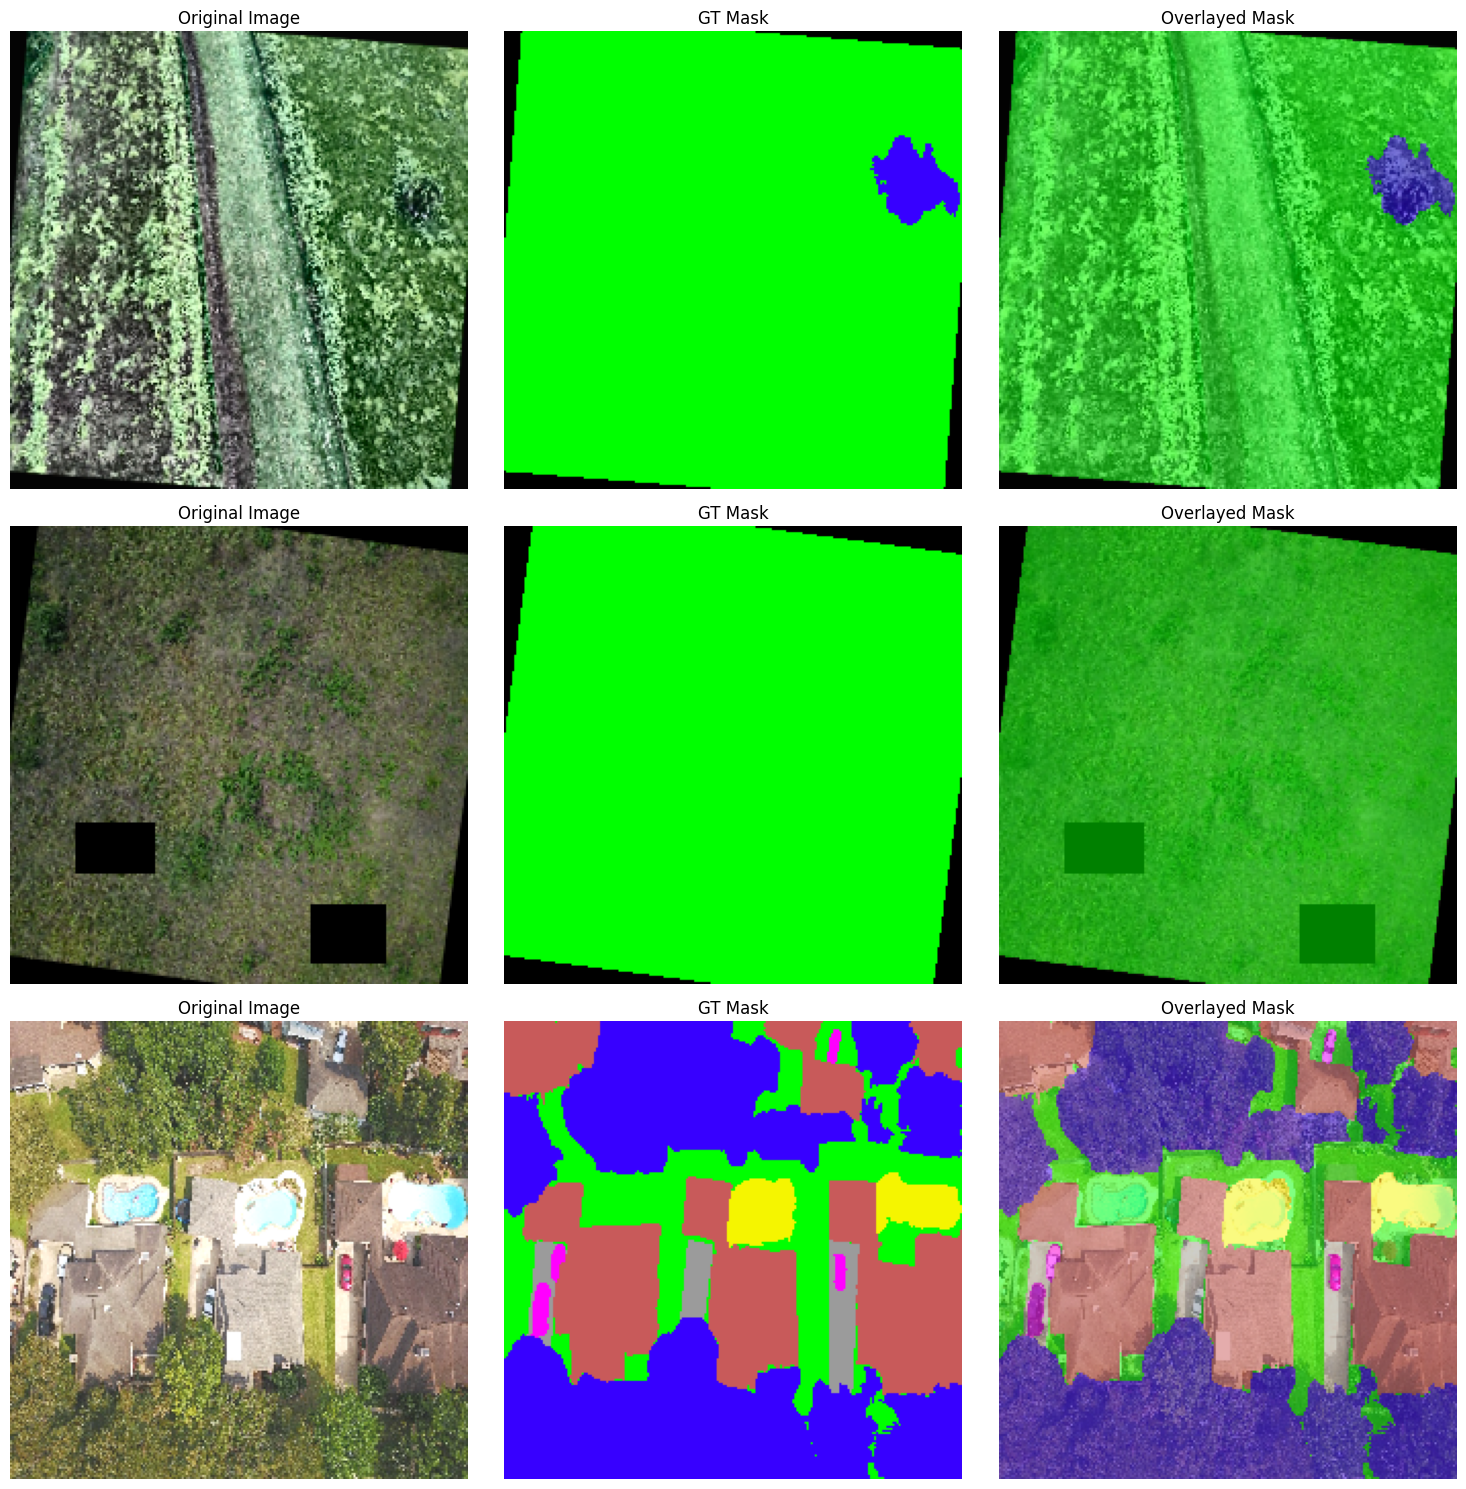

In [ ]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=random_state, shuffle=True
)

train_ds = CustomSegmentationDataset(
    batch_size=TrainingConfig.BATCH_SIZE,
    image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
    image_paths=train_images,
    mask_paths=train_masks,
    num_classes=DatasetConfig.NUM_CLASSES,
    apply_aug=True
)

val_ds = CustomSegmentationDataset(
    batch_size=TrainingConfig.BATCH_SIZE,
    image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
    image_paths=val_images,
    mask_paths=val_masks,
    num_classes=DatasetConfig.NUM_CLASSES,
    apply_aug=False
)

display_samples(train_ds, num_samples=3)

## 3. Loss Function

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """Compute Dice loss."""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def categorical_crossentropy_loss(y_true, y_pred):
    """Compute categorical crossentropy loss."""
    return tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Combine Dice loss and categorical crossentropy loss."""
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * categorical_crossentropy_loss(y_true, y_pred)

## 4. Evaluation Metrics

The mean <a href="https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient" target="_blank">Dice coefficient</a>,  which helps compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:


<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be $1$ when both $X$ and $Y$ are empty.</p>



In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Compute Dice coefficient."""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

## 5. Model

In [ ]:
def transfer_learning_unet(input_shape=(224,224,3), num_classes=10):
    """
    Build a U-Net segmentation model using a pre-trained VGG16 encoder.
    The encoder's weights are frozen during the feature extraction phase.
    """
    # Load pre-trained VGG16 without the top layers
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Extract feature maps for skip connections
    block1_out = base_model.get_layer("block1_pool").output   # (112,112,64)
    block2_out = base_model.get_layer("block2_pool").output   # (56,56,128)
    block3_out = base_model.get_layer("block3_pool").output   # (28,28,256)
    block4_out = base_model.get_layer("block4_pool").output   # (14,14,512)

    # Freeze encoder layers for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Bottleneck: use the output of block5_pool
    bottleneck = base_model.get_layer("block5_pool").output    # (7,7,512)

    # Decoder: Upsample and concatenate with corresponding encoder outputs
    u1 = UpSampling2D((2,2))(bottleneck)            # (14,14,512)
    u1 = Concatenate()([u1, block4_out])             # (14,14,1024)
    c5 = Conv2D(512, (3,3), activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(512, (3,3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D((2,2))(c5)                    # (28,28,512)
    u2 = Concatenate()([u2, block3_out])            # (28,28,768)
    c6 = Conv2D(256, (3,3), activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(256, (3,3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D((2,2))(c6)                    # (56,56,256)
    u3 = Concatenate()([u3, block2_out])            # (56,56,384)
    c7 = Conv2D(128, (3,3), activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(128, (3,3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u4 = UpSampling2D((2,2))(c7)                    # (112,112,128)
    u4 = Concatenate()([u4, block1_out])            # (112,112,192)
    c8 = Conv2D(64, (3,3), activation='relu', padding='same')(u4)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(64, (3,3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    # Additional upsampling to recover the original resolution (224x224)
    u5 = UpSampling2D((2,2))(c8)                    # (224,224,64)
    c9 = Conv2D(32, (3,3), activation='relu', padding='same')(u5)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(32, (3,3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c9)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
model_pretrained = transfer_learning_unet(input_shape=(224,224,3), num_classes=DatasetConfig.NUM_CLASSES)

# Define callbacks for training
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_dice_coefficient", mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
callbacks = [checkpoint, reduce_lr, early_stopping]

# Compile the model for the feature extraction stage
optimizer = Adam(learning_rate=TrainingConfig.LEARNING_RATE)
model_pretrained.compile(optimizer=optimizer, loss=combined_loss, metrics=["accuracy", dice_coefficient])
model_pretrained.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 24,927,050 (95.09 MB)

 Trainable params: 10,208,394 (38.94 MB)

 Non-trainable params: 14,718,656 (56.15 MB)

In [ ]:
history_feature_extraction = model_pretrained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TrainingConfig.EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.4842 - dice_coefficient: 0.3212 - loss: 1.2529
Epoch 1: val_dice_coefficient improved from -inf to 0.57645, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 204s 1000ms/step - accuracy: 0.4851 - dice_coefficient: 0.3219 - loss: 1.2514 - val_accuracy: 0.7705 - val_dice_coefficient: 0.5764 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 2/35
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7649 - dice_coefficient: 0.5984 - loss: 0.6971
Epoch 2: val_dice_coefficient improved from 0.57645 to 0.69687, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 180s 981ms/step - accuracy: 0.7649 - dice_coefficient: 0.5985 - loss: 0.6969 - val_accuracy: 0.8184 - val_dice_coefficient: 0.6969 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 3/35
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7861 - dice_coefficient: 0.6529 - loss: 0.6037
Epoch 3: val_dice_coefficient improved from 0.696

In [ ]:
early_stopping_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coefficient",
    patience=4,  # Stop if no improvement in 4 epochs
    mode="max",  # Ensure Keras maximizes Dice coefficient
    restore_best_weights=True
)
callbacks_ft = [checkpoint, reduce_lr, early_stopping_ft]

In [ ]:
# Fine Tuning
# Unfreeze all layers for fine-tuning
for layer in model_pretrained.layers:
    layer.trainable = True

model_pretrained.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE_FT),
                         loss=combined_loss, metrics=["accuracy", dice_coefficient])
history_fine_tuning = model_pretrained.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TrainingConfig.EPOCHS_FT,
    callbacks=callbacks_ft
)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9345 - dice_coefficient: 0.9085 - loss: 0.1455
Epoch 1: val_dice_coefficient improved from 0.86810 to 0.87082, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 204s 1000ms/step - accuracy: 0.9345 - dice_coefficient: 0.9085 - loss: 0.1455 - val_accuracy: 0.8954 - val_dice_coefficient: 0.8708 - val_loss: 0.2531 - learning_rate: 1.0000e-06
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9355 - dice_coefficient: 0.9091 - loss: 0.1444
Epoch 2: val_dice_coefficient did not improve from 0.87082
184/184 ━━━━━━━━━━━━━━━━━━━━ 181s 984ms/step - accuracy: 0.9355 - dice_coefficient: 0.9091 - loss: 0.1445 - val_accuracy: 0.8949 - val_dice_coefficient: 0.8700 - val_loss: 0.2536 - learning_rate: 1.0000e-06
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9350 - dice_coefficient: 0.9078 - loss: 0.1467
Epoch 3: val_dice_coefficient did not improve from 0.87082
184/184 ━━━━━━━━━━━━━━━━━

## 6. Train and Plot Results

In [ ]:
def plot_training_history(history_fe, history_ft, separation_epoch):
    plt.figure(figsize=(14,6))

    # Combine loss curves
    combined_loss_curve = history_fe.history["loss"] + history_ft.history["loss"]
    combined_val_loss = history_fe.history["val_loss"] + history_ft.history["val_loss"]
    total_epochs = len(combined_loss_curve)
    epochs = list(range(1, total_epochs + 1))

    plt.subplot(1,2,1)
    plt.plot(epochs, combined_loss_curve, label="Train Loss")
    plt.plot(epochs, combined_val_loss, label="Val Loss")
    plt.axvline(x=separation_epoch, color='red', linestyle='--', linewidth=2, label="Fine-tuning starts")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Combine Dice coefficient curves
    combined_dice = history_fe.history["dice_coefficient"] + history_ft.history["dice_coefficient"]
    combined_val_dice = history_fe.history["val_dice_coefficient"] + history_ft.history["val_dice_coefficient"]

    plt.subplot(1,2,2)
    plt.plot(epochs, combined_dice, label="Train Dice")
    plt.plot(epochs, combined_val_dice, label="Val Dice")
    plt.axvline(x=separation_epoch, color='red', linestyle='--', linewidth=2, label="Fine-tuning starts")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.title("Training & Validation Dice Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

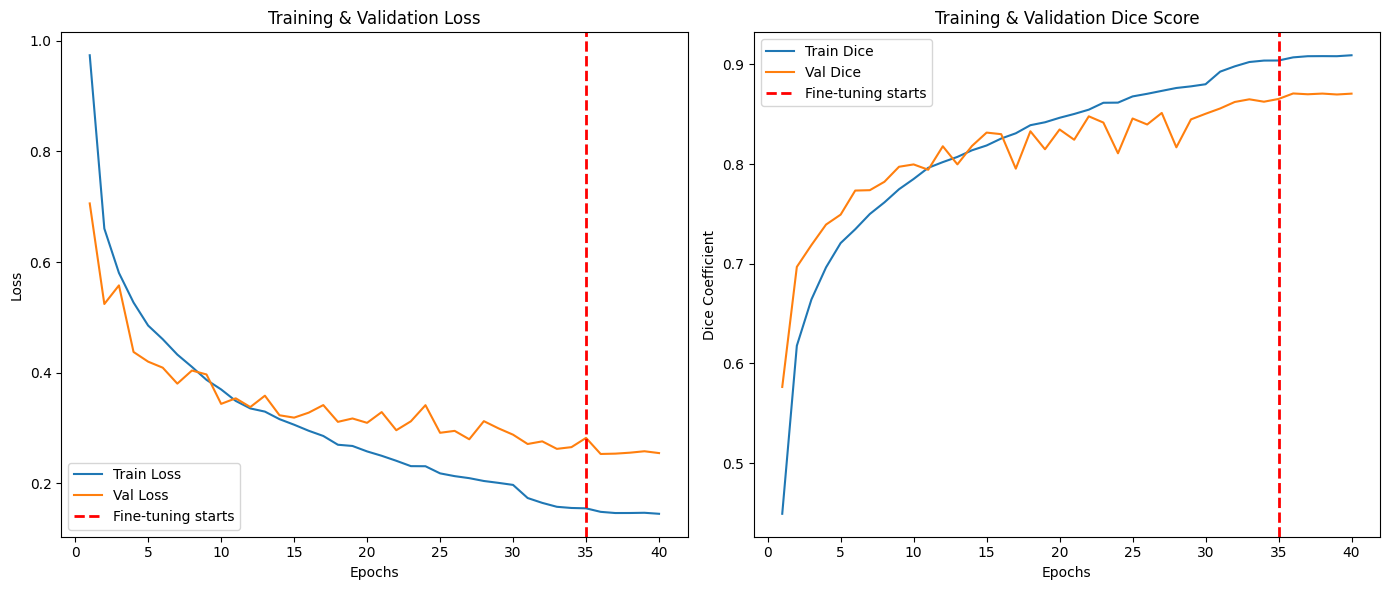

In [ ]:
# Use the number of epochs from the feature extraction phase as the separation point.
plot_training_history(history_feature_extraction, history_fine_tuning, separation_epoch=TrainingConfig.EPOCHS)

## 7. Inference


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


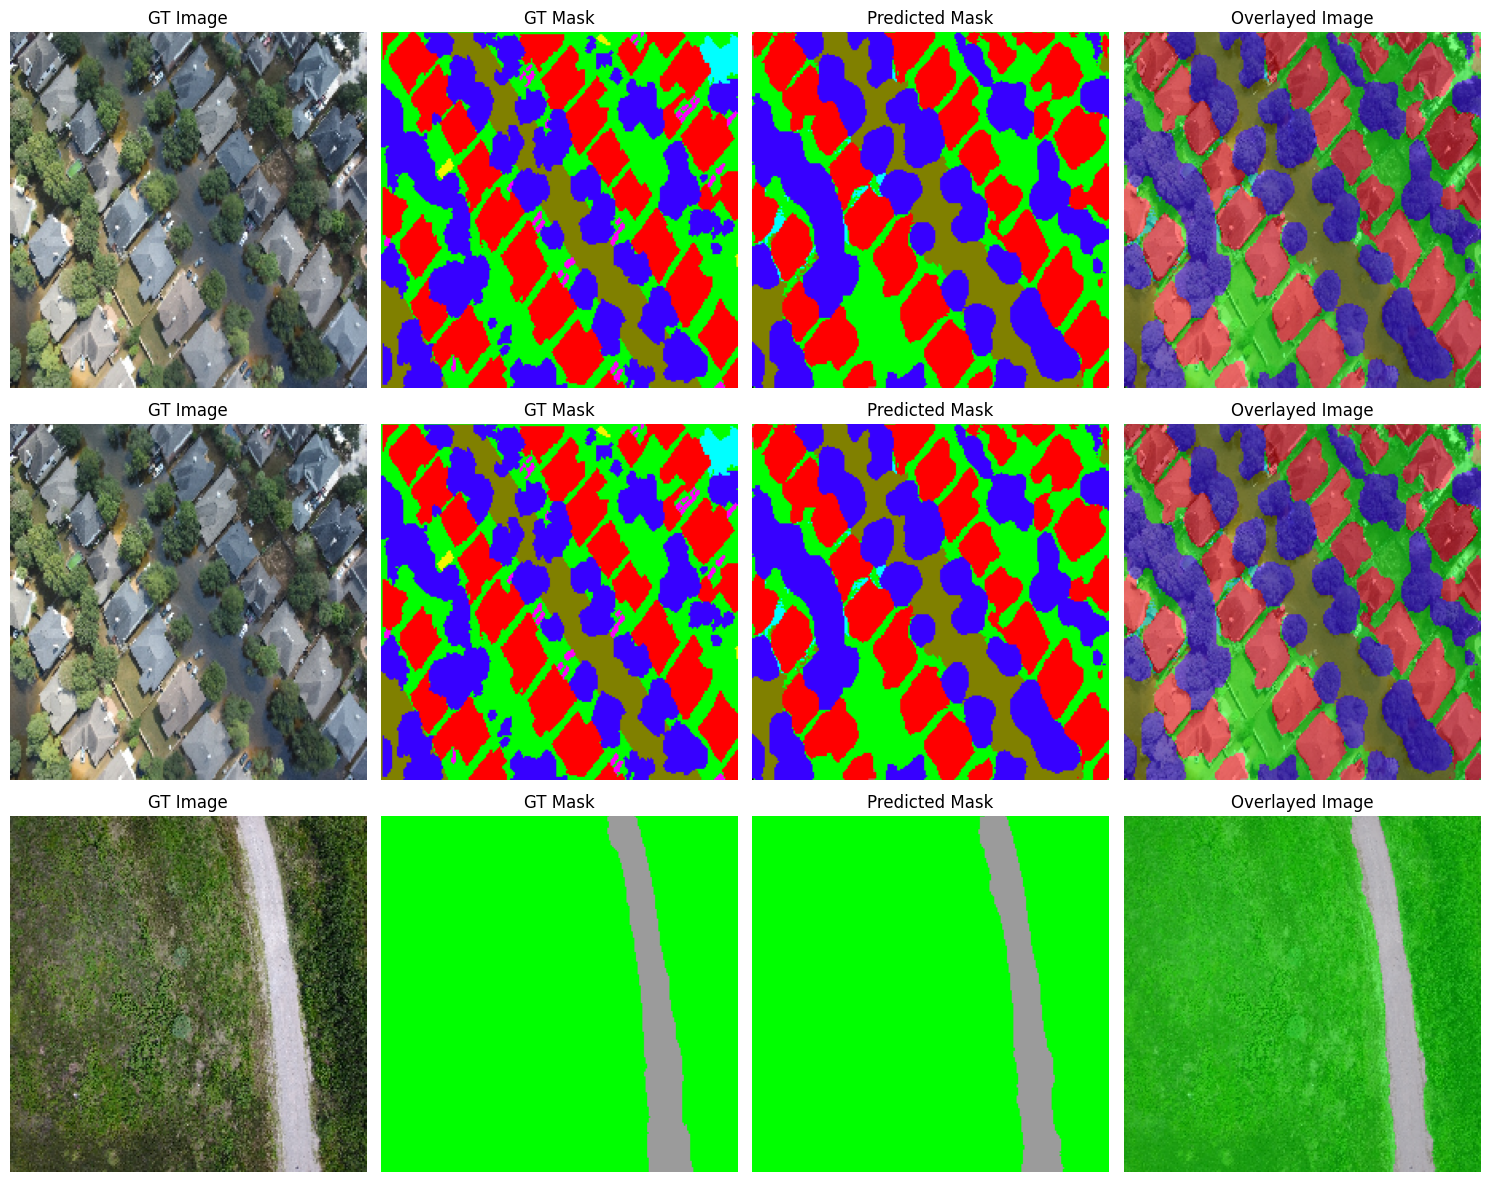

In [ ]:
def inference_and_plot(model, dataset, num_samples=3, color_map=id2color):
    plt.figure(figsize=(15, num_samples * 4))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        images, masks = dataset[idx]
        image = images[0]
        gt_mask = np.argmax(masks[0], axis=-1)
        pred_mask = model.predict(image[np.newaxis, ...])[0]
        pred_mask = np.argmax(pred_mask, axis=-1)
        gt_rgb_mask = num_to_rgb(gt_mask, color_map)
        pred_rgb_mask = num_to_rgb(pred_mask, color_map)
        overlay = image_overlay(image, pred_rgb_mask)

        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(image)
        plt.title("GT Image")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(gt_rgb_mask)
        plt.title("GT Mask")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(pred_rgb_mask)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(overlay)
        plt.title("Overlayed Image")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

inference_and_plot(model_pretrained, val_ds)

## 8. Prepare Submission CSV

In [ ]:
def rle_encode(mask):
    """
    Efficient implementation of RLE encoding for a binary mask.

    Parameters:
      mask (numpy array): Binary mask for a specific class.

    Returns:
      str: RLE encoded string.
    """
    # Transpose the mask for Kaggle RLE format (top-to-bottom, then left-to-right)
    pixels = mask.T.flatten()
    pixels = np.pad(pixels, ((1, 1),))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def create_submission_csv(model, test_csv_path, test_image_folder, output_csv="submission.csv"):
    """
    Generate a submission CSV file with run-length encoding for each class per test image.

    For each test image, the submission will contain NUM_CLASSES rows in the format:
      {image_name}_{class_id:02d}, RLE_encoded_mask
    """
    import pandas as pd
    logging.info("Starting submission CSV creation process.")
    submission_data = []
    try:
        test_df = pd.read_csv(test_csv_path, header=None, names=["IMG_ID"])
    except Exception as e:
        logging.error(f"Failed to read test CSV: {e}")
        return

    # Process each unique test image once.
    unique_images = sorted(set([x.split('_')[0] for x in test_df["IMG_ID"].tolist()]))
    for base_name in unique_images:
        image_path = os.path.join(test_image_folder, f"{base_name}.jpg")
        if not os.path.exists(image_path):
            logging.warning(f"Test image not found: {image_path}. Skipping.")
            continue

        original_image = cv2.imread(image_path)
        if original_image is None:
            logging.warning(f"Failed to load test image: {image_path}. Skipping.")
            continue
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = original_image.shape[:2]

        # Preprocess: normalize and resize to model input dimensions
        image = original_image.astype(np.float32) / 255.0
        image_resized = cv2.resize(image, (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT))
        try:
            pred = model.predict(image_resized[np.newaxis, ...])[0]
        except Exception as e:
            logging.error(f"Error during prediction for image {base_name}: {e}")
            continue

        # Get predicted class mask and resize back to original dimensions
        pred_class = np.argmax(pred, axis=-1)
        pred_resized = cv2.resize(pred_class, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

        # For each class, generate RLE string
        for class_id in range(DatasetConfig.NUM_CLASSES):
            binary_mask = (pred_resized == class_id).astype(np.uint8)
            rle = rle_encode(binary_mask) if np.sum(binary_mask) > 0 else ""
            submission_data.append([f"{base_name}_{class_id:02d}", rle])

    submission_df = pd.DataFrame(submission_data, columns=["IMG_ID", "EncodedString"])
    try:
        submission_df.to_csv(output_csv, index=False)
        logging.info(f"Submission CSV saved as {output_csv}")
    except Exception as e:
        logging.error(f"Error saving CSV: {e}")

In [ ]:
test_csv_path = "./dataset/test.csv"
test_image_folder = "./dataset/Project_3_FloodNet_Dataset/test/images/"
create_submission_csv(model_pretrained, test_csv_path, test_image_folder, output_csv="submission.csv")
print("Submission CSV created successfully.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

Submission CSV created successfully.
